<a href="https://colab.research.google.com/github/georgezoto/Coding-in-TensorFlow/blob/master/Time-Series-Prediction/Weather_data_Madrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Time Series Prediction: Weather data Madrid, using ML and Deep Learning

**Meetup event, come and join us 😀**  
https://www.meetup.com/Deep-Learning-Adventures/events/272091576/

**Deep Learning YouTube recordings, feel free to share and subscribe 😀**  
https://bit.ly/deep-learning-tf  
https://bit.ly/deep-learning-tf-coding  

**Weather data Barajas Airport, Madrid, between 1997 and 2015 🎉**   
Gathered web https://www.wunderground.com/ The Weather Company, LLC  

https://www.kaggle.com/juliansimon/weather_madrid_lemd_1997_2015.csv

Inspired by Sunspot activity time series prediction in TensorFlow in Practice Specialization notebook at: 
https://github.com/georgezoto/TensorFlow-in-Practice/blob/master/C4W4_2_Sunspots_Conv1D_Multi_LSTM_Dense_Lambda_Huber_learning_rate_mae.ipynb  

![alt text](https://secure.meetupstatic.com/photos/event/d/b/a/1/highres_491456225.jpeg)

In [1]:
import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
seed = 51
tf.random.set_seed(seed)
random.seed(seed)

2.3.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Get the data
First download the dataset.

In [2]:
# upload the kaggle.json file from local computer
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)
-rw-r--r-- 1 root root 66 Sep  1 18:51 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d juliansimon/weather_madrid_lemd_1997_2015.csv

  0% 0.00/145k [00:00<?, ?B/s]
100% 145k/145k [00:00<00:00, 55.3MB/s]


In [5]:
!unzip weather_madrid_lemd_1997_2015.csv.zip > /dev/null

In [6]:
dataset_path = '/content/weather_madrid_LEMD_1997_2015.csv'
dataset_path

'/content/weather_madrid_LEMD_1997_2015.csv'

In [7]:
!head $dataset_path

CET,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity, Mean Humidity, Min Humidity, Max Sea Level PressurehPa, Mean Sea Level PressurehPa, Min Sea Level PressurehPa, Max VisibilityKm, Mean VisibilityKm, Min VisibilitykM, Max Wind SpeedKm/h, Mean Wind SpeedKm/h, Max Gust SpeedKm/h,Precipitationmm, CloudCover, Events,WindDirDegrees
1997-1-1,7,4,2,5,3,2,100,95,76,1010,1008,1004,10,9,4,13,6,,0.00,6,,229
1997-1-2,7,3,0,6,3,0,100,92,71,1007,1003,997,10,9,4,26,8,47,0.00,5,Rain,143
1997-1-3,5,3,2,5,1,-1,100,85,70,1005,999,996,10,10,7,27,19,,0.00,6,Rain-Snow,256
1997-1-4,7,3,-1,-2,-3,-4,86,63,49,1012,1010,1005,10,10,10,27,19,40,0.00,2,,284
1997-1-5,2,0,-1,2,0,-3,100,95,86,1012,1008,1005,10,5,1,14,6,,0.00,7,Snow,2
1997-1-6,7,3,1,2,-1,-3,100,82,57,1014,1010,1008,10,10,10,11,5,,0.00,4,,64
1997-1-7,2,0,-2,1,-1,-3,100,93,75,1016,1014,1009,10,7,0,6,2,,0.00,7,Snow,43
1997-1-8,8,4,1,7,4,1,100,96,87,1015,1005,1003,10,8,4,26,8,,0.00,7,Rain,273
1997-1

### Import dataset using pandas

In [8]:
dataset = pd.read_csv(dataset_path, parse_dates=['CET'])
dataset.rename(columns={'CET':'Date', ' CloudCover':'CloudCover', ' Events':'Events Original'}, inplace=True)
dataset.head()

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events Original,WindDirDegrees
0,1997-01-01,7.0,4.0,2.0,5.0,3.0,2.0,100.0,95.0,76.0,1010,1008,1004,10.0,9.0,4.0,13,6,NaN,0.0,6.0,NaN,229
1,1997-01-02,7.0,3.0,0.0,6.0,3.0,0.0,100.0,92.0,71.0,1007,1003,997,10.0,9.0,4.0,26,8,47.0,0.0,5.0,Rain,143
2,1997-01-03,5.0,3.0,2.0,5.0,1.0,-1.0,100.0,85.0,70.0,1005,999,996,10.0,10.0,7.0,27,19,NaN,0.0,6.0,Rain-Snow,256
3,1997-01-04,7.0,3.0,-1.0,-2.0,-3.0,-4.0,86.0,63.0,49.0,1012,1010,1005,10.0,10.0,10.0,27,19,40.0,0.0,2.0,NaN,284
4,1997-01-05,2.0,0.0,-1.0,2.0,0.0,-3.0,100.0,95.0,86.0,1012,1008,1005,10.0,5.0,1.0,14,6,NaN,0.0,7.0,Snow,2


In [9]:
dataset.shape

(6812, 23)

In [10]:
dataset.dtypes

Date                           datetime64[ns]
Max TemperatureC                      float64
Mean TemperatureC                     float64
Min TemperatureC                      float64
Dew PointC                            float64
MeanDew PointC                        float64
Min DewpointC                         float64
Max Humidity                          float64
 Mean Humidity                        float64
 Min Humidity                         float64
 Max Sea Level PressurehPa              int64
 Mean Sea Level PressurehPa             int64
 Min Sea Level PressurehPa              int64
 Max VisibilityKm                     float64
 Mean VisibilityKm                    float64
 Min VisibilitykM                     float64
 Max Wind SpeedKm/h                     int64
 Mean Wind SpeedKm/h                    int64
 Max Gust SpeedKm/h                   float64
Precipitationmm                       float64
CloudCover                            float64
Events Original                   

In [11]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
dataset['Events'] = labelencoder.fit_transform(dataset['Events Original'].astype(str))
dataset[['Events Original', 'Events']].head(10)

,Events Original,Events
0,NaN,15
1,Rain,6
2,Rain-Snow,9
3,NaN,15
4,Snow,12
5,NaN,15
6,Snow,12
7,Rain,6
8,Rain,6
9,NaN,15


### Data Exploration

In [12]:
#Pandas plot
#dataset['Max TemperatureC'].value_counts().sort_values().plot(kind = 'bar');
#dataset['Max TemperatureC'].plot.hist(title='Max TemperatureC', bins=24, figsize=(16,9));

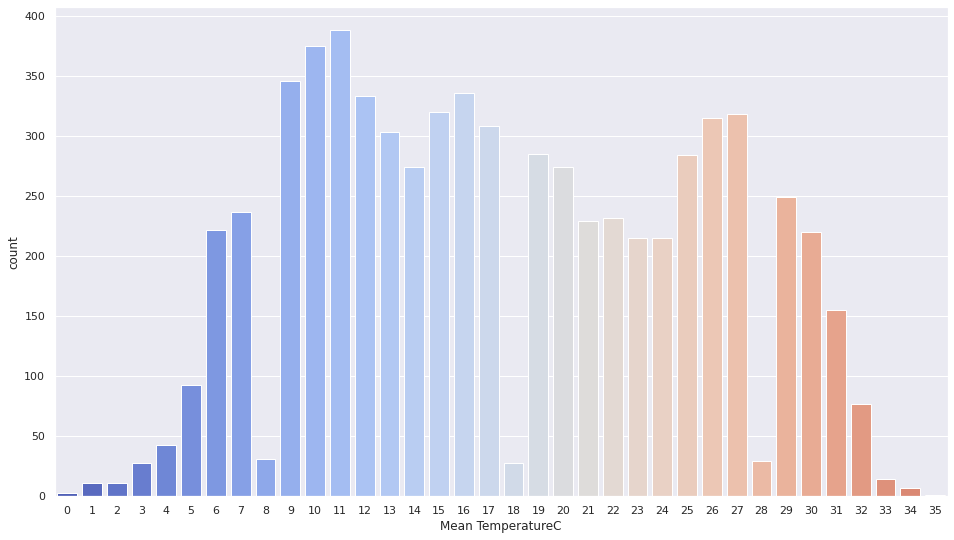

In [13]:
#Seaborn plot
sns.set(rc={'figure.figsize':(16,9)})
sns.countplot(x="Mean TemperatureC", data=dataset, palette=sns.color_palette("coolwarm", 42)).settitle=('Mean TemperatureC');

#Plot float as in in x-axis
from  matplotlib.ticker import FuncFormatter
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

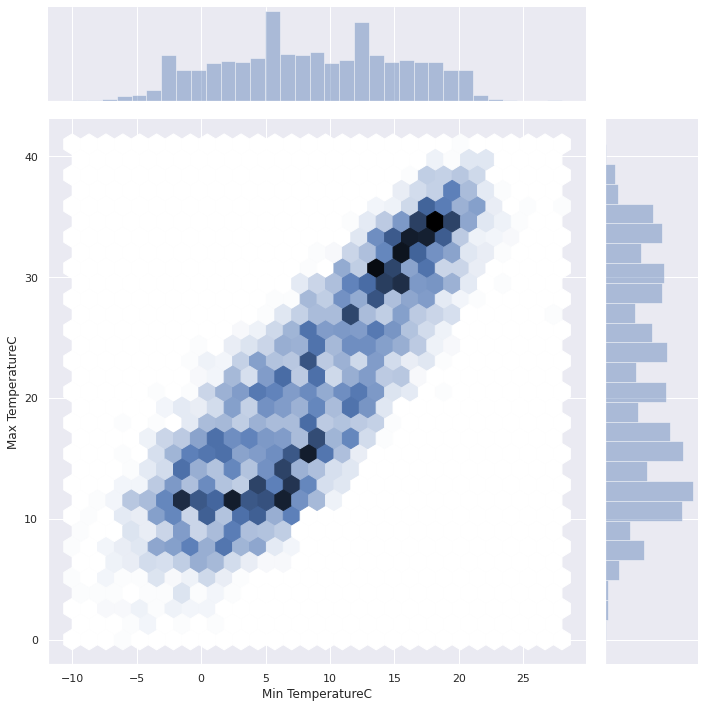

In [14]:
#kind{ scatter | reg | resid | kde | hex }
sns.jointplot(x='Min TemperatureC', y='Max TemperatureC', data=dataset, kind="hex", height=10); 

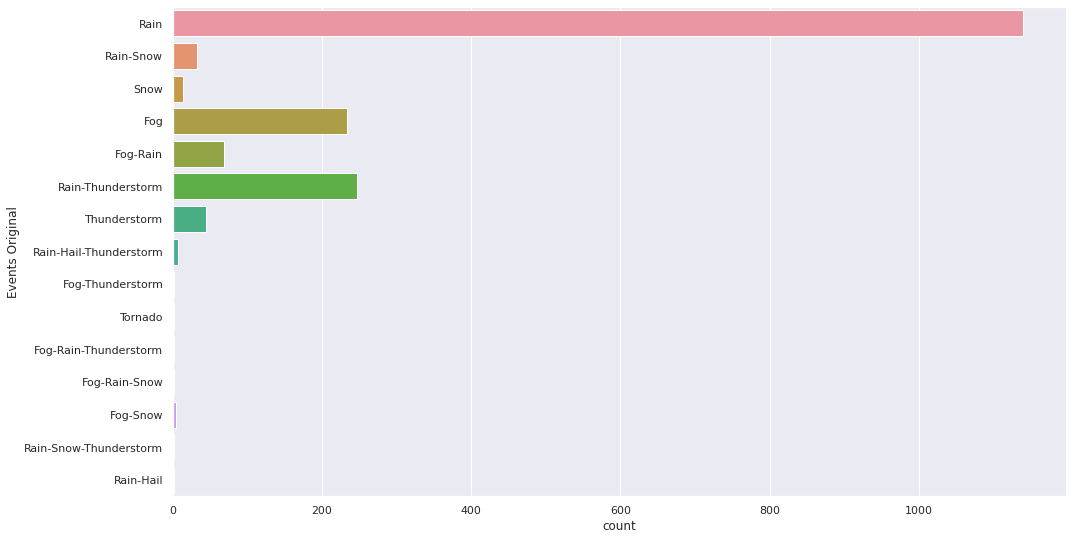

In [15]:
sns.countplot(y="Events Original", data=dataset);

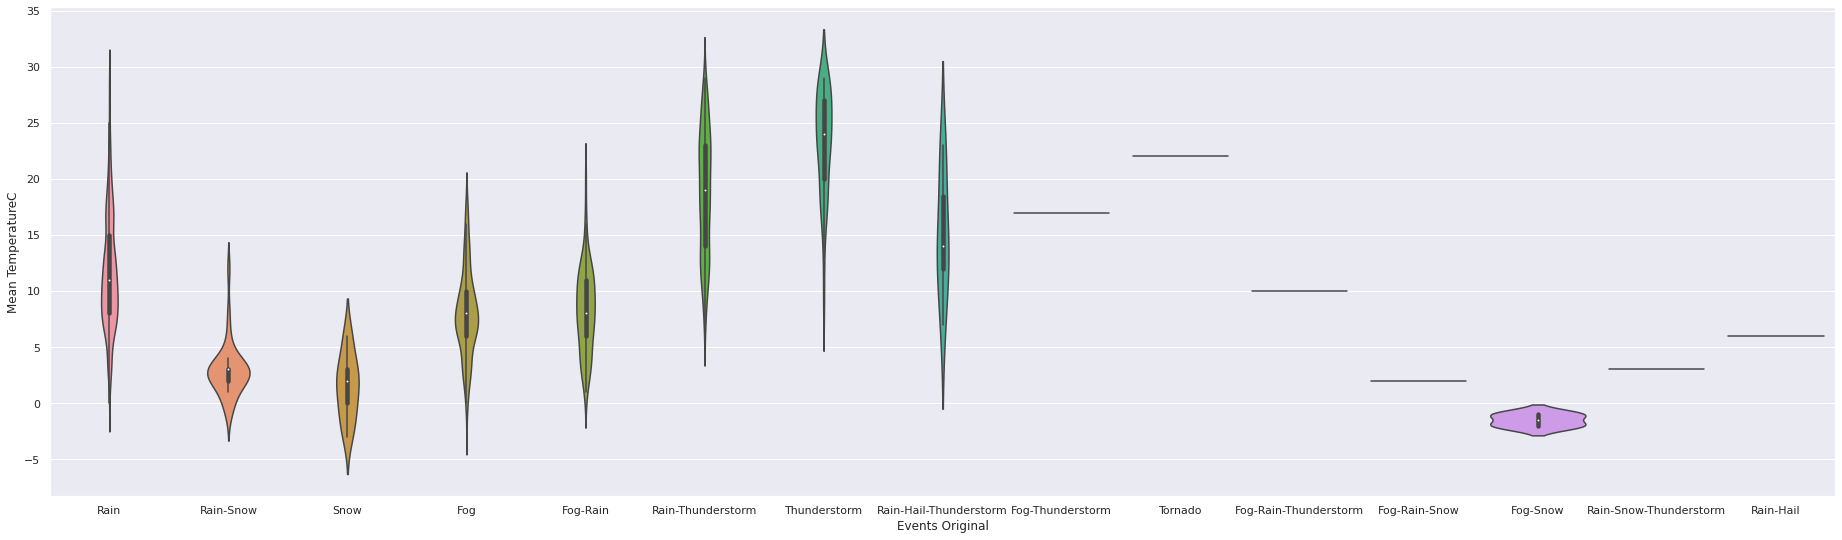

In [16]:
sns.set(rc={'figure.figsize':(32,9)})
sns.violinplot(x="Events Original", y="Mean TemperatureC", data=dataset);

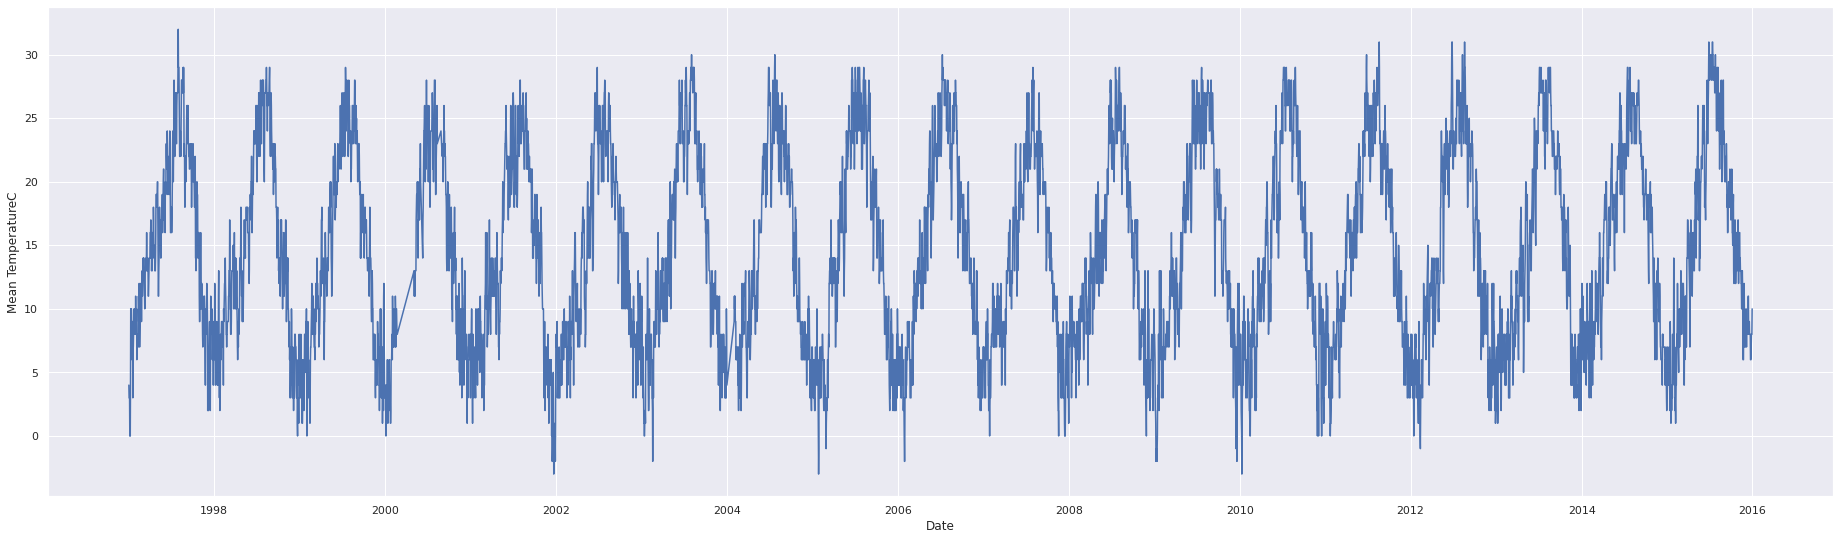

In [17]:
sns.lineplot(x="Date", y="Mean TemperatureC", data=dataset);

### Check for missing dates

In [18]:
dataset['Date']

0      1997-01-01
1      1997-01-02
2      1997-01-03
3      1997-01-04
4      1997-01-05
          ...    
6807   2015-12-27
6808   2015-12-28
6809   2015-12-29
6810   2015-12-30
6811   2015-12-31
Name: Date, Length: 6812, dtype: datetime64[ns]

In [19]:
missing_dates = pd.date_range(start = '1997-01-01', end = '2015-12-31' ).difference(dataset['Date'])
len(missing_dates)

127

In [20]:
list(missing_dates)

[Timestamp('2000-02-23 00:00:00'),
 Timestamp('2000-02-24 00:00:00'),
 Timestamp('2000-02-25 00:00:00'),
 Timestamp('2000-02-26 00:00:00'),
 Timestamp('2000-02-27 00:00:00'),
 Timestamp('2000-02-28 00:00:00'),
 Timestamp('2000-02-29 00:00:00'),
 Timestamp('2000-03-01 00:00:00'),
 Timestamp('2000-03-02 00:00:00'),
 Timestamp('2000-03-03 00:00:00'),
 Timestamp('2000-03-04 00:00:00'),
 Timestamp('2000-03-05 00:00:00'),
 Timestamp('2000-03-06 00:00:00'),
 Timestamp('2000-03-07 00:00:00'),
 Timestamp('2000-03-08 00:00:00'),
 Timestamp('2000-03-09 00:00:00'),
 Timestamp('2000-03-10 00:00:00'),
 Timestamp('2000-03-11 00:00:00'),
 Timestamp('2000-03-12 00:00:00'),
 Timestamp('2000-03-13 00:00:00'),
 Timestamp('2000-03-14 00:00:00'),
 Timestamp('2000-03-15 00:00:00'),
 Timestamp('2000-03-16 00:00:00'),
 Timestamp('2000-03-17 00:00:00'),
 Timestamp('2000-03-18 00:00:00'),
 Timestamp('2000-03-19 00:00:00'),
 Timestamp('2000-03-20 00:00:00'),
 Timestamp('2000-03-21 00:00:00'),
 Timestamp('2000-03-

### Keep only records from '2004-02-01' and forward

In [21]:
dataset_original = dataset.copy(deep=True)

In [22]:
dataset.shape

(6812, 24)

In [23]:
dataset = dataset[dataset['Date'] >= '2004-02-01'].reset_index(drop=True)
dataset.shape

(4352, 24)

### Distribution and Correlation plots for key fields

In [24]:
mean_dataset = dataset[['Mean TemperatureC', 'MeanDew PointC', ' Mean Humidity', ' Mean Sea Level PressurehPa', ' Mean VisibilityKm', ' Mean Wind SpeedKm/h',
                        'Precipitationmm', 'CloudCover', 'WindDirDegrees', 'Events']]

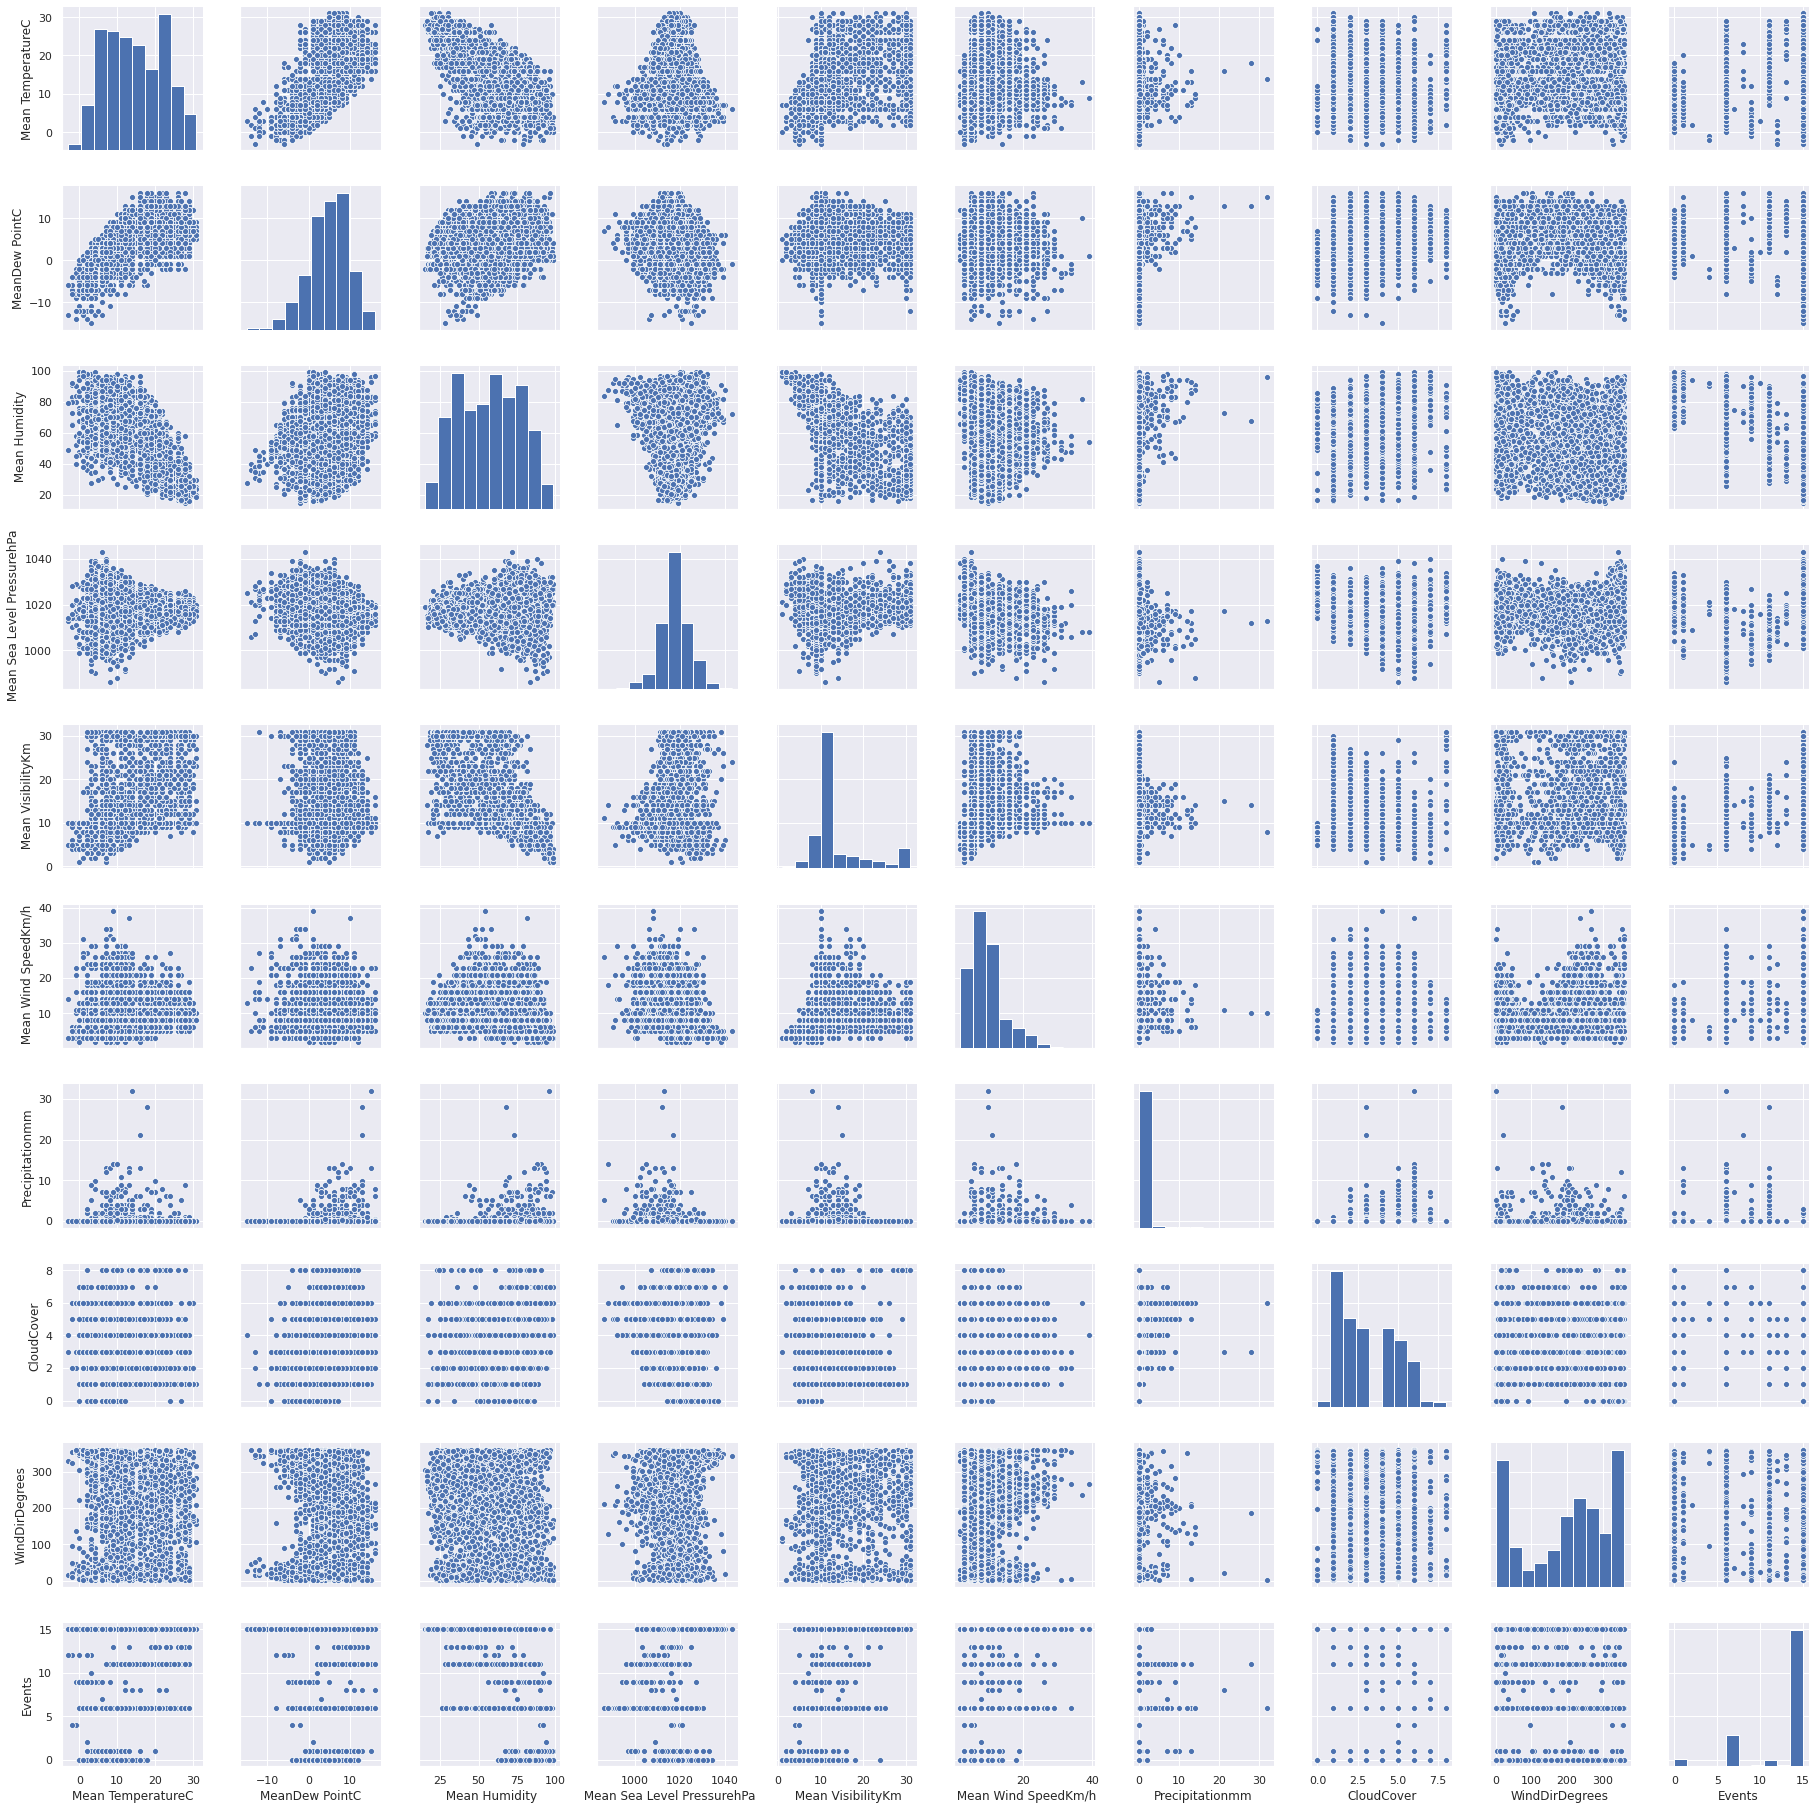

In [ ]:
#This take a while to run
sns.pairplot(mean_dataset);

### Train, Validaton and Test split

In [25]:
#Helpful method to plot series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

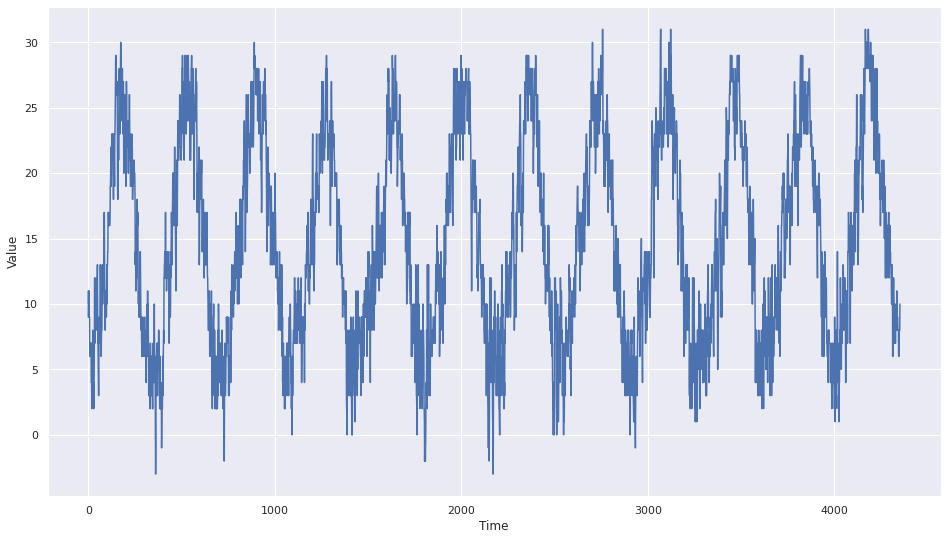

In [26]:
series = np.array(dataset['Mean TemperatureC'])
time = np.array(dataset.index)
plt.figure(figsize=(16, 9))
plot_series(time, series)

In [27]:
time

array([   0,    1,    2, ..., 4349, 4350, 4351])

In [28]:
dataset[dataset['Date'] == '2012-12-31']

,Date,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events Original,WindDirDegrees,Events
3256,2012-12-31,4.0,2.0,1.0,3.0,2.0,1.0,100.0,98.0,81.0,1034,1027,1021,8.0,3.0,0.0,14,5,NaN,2.03,6.0,Fog-Rain,147,1


In [29]:
dataset[dataset['Date'] == '2012-12-31'].index[0]

3256

In [30]:
dataset.shape

(4352, 24)

In [31]:
split_time = dataset[dataset['Date'] == '2012-12-31'].index[0] + 1
time_train = time[:split_time]
x_train = series[:split_time]

time_test = time[split_time:]
x_test = series[split_time:]

validation_split_time = dataset[dataset['Date'] == '2010-12-31'].index[0] + 1
time_valid = time_train[validation_split_time:]
x_valid = x_train[validation_split_time:]

### Useful pre and post processing methods

In [32]:
def windowed_dataset_dnn(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [35]:
def plot_results(history):
  history = history.history

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(16, 9))

  ax1.plot(history['loss'], label='Train loss')
  #ax1.plot(history['val_loss'], label='Validation loss')
  ax1.legend(loc='best')
  ax1.set_title('Loss')

  ax2.plot(history['mae'], label='Train mae')
  #ax2.plot(history['val_mae'], label='Validation mae')
  ax2.legend(loc='best')
  ax2.set_title('MAE')

  plt.xlabel('Epochs')
  sns.despine()
  plt.show()

In [84]:
def plot_multiple_results(history_list, offset=0):
  fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(16, 9))

  count = 0
  for history in history_list:
    count+=1
    history = history.history
  
    ax1.plot(history['loss'][offset:], label='Train loss-v'+str(count))
    #ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend(loc='best')
    ax1.set_title('Loss')

    ax2.plot(history['mae'][offset:], label='Train mae-v'+str(count))
    #ax2.plot(history['val_mae'], label='Validation mae')
    ax2.legend(loc='best')
    ax2.set_title('MAE')

    plt.xlabel('Epochs')
    sns.despine()
plt.show()

## Model v1 - 3 layer DNN - MAE: 2.0

### Hyperparameter tuning

In [121]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

train_set =      windowed_dataset_dnn(x_train, window_size, batch_size, shuffle_buffer_size)
validation_set = windowed_dataset_dnn(x_valid, window_size, batch_size, shuffle_buffer_size)
test_set =       windowed_dataset_dnn(x_test, window_size, batch_size, shuffle_buffer_size)

### Model architecture

In [123]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1)
])

#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics=['mae']) 
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


### Setup and train our model

In [124]:
checkpoint_filepath = 'Time-Series-Prediction-Weather-data-Madrid-v1.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_loss', mode='auto', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [125]:
history_v1 = model.fit(train_set,
                       validation_data = validation_set,
                       epochs=100,
                       verbose=1,
                       callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
101/101 [==============================] - 1s 6ms/step - loss: 19.3620 - mae: 3.1259 - val_loss: 6.9863 - val_mae: 2.0967
Epoch 2/100
101/101 [==============================] - 1s 5ms/step - loss: 6.9197 - mae: 2.0953 - val_loss: 5.9582 - val_mae: 1.9213
Epoch 3/100
101/101 [==============================] - 0s 5ms/step - loss: 5.8062 - mae: 1.9173 - val_loss: 5.1383 - val_mae: 1.7986
Epoch 4/100
101/101 [==============================] - 1s 5ms/step - loss: 5.1782 - mae: 1.8143 - val_loss: 4.7219 - val_mae: 1.7239
Epoch 5/100
101/101 [==============================] - 1s 5ms/step - loss: 4.8939 - mae: 1.7538 - val_loss: 5.1248 - val_mae: 1.7550
Epoch 6/100
101/101 [==============================] - 1s 5ms/step - loss: 4.7728 - mae: 1.7298 - val_loss: 4.6136 - val_mae: 1.6633
Epoch 7/100
101/101 [==============================] - 1s 5ms/step - loss: 4.4661 - mae: 1.6716 - val_loss: 4.1387 - val_mae: 1.6085
Epoch 8/100
101/101 [==============================] - 1s 5ms/step -

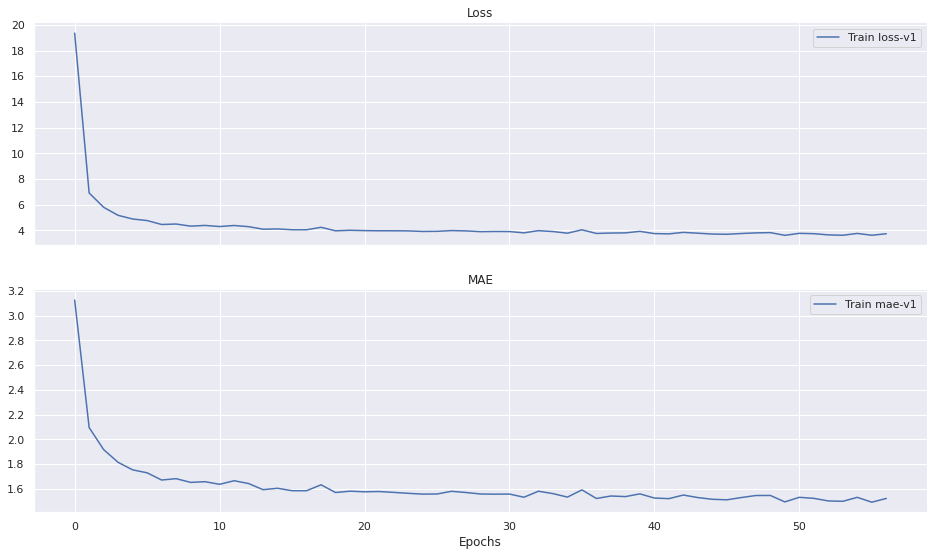

In [126]:
plot_multiple_results([history_v1])

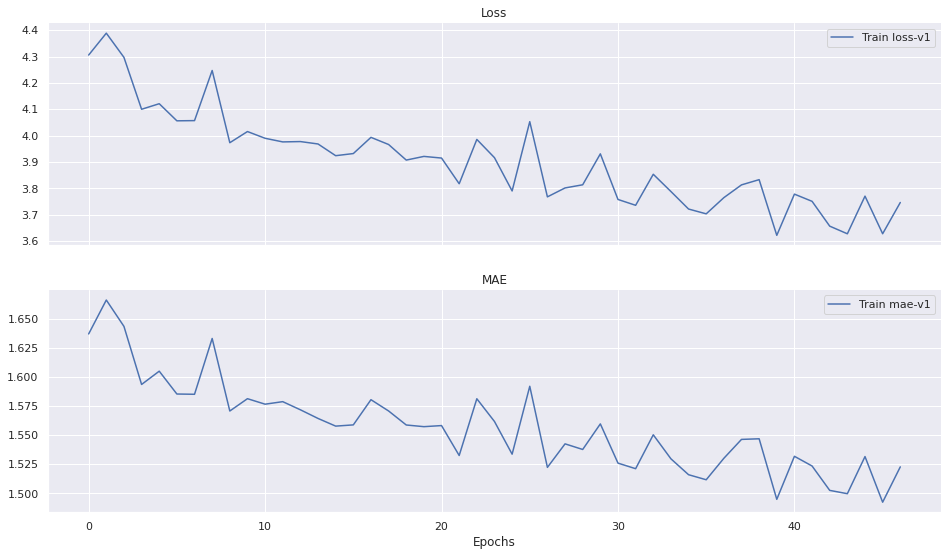

In [127]:
plot_multiple_results([history_v1], offset=10)

In [128]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

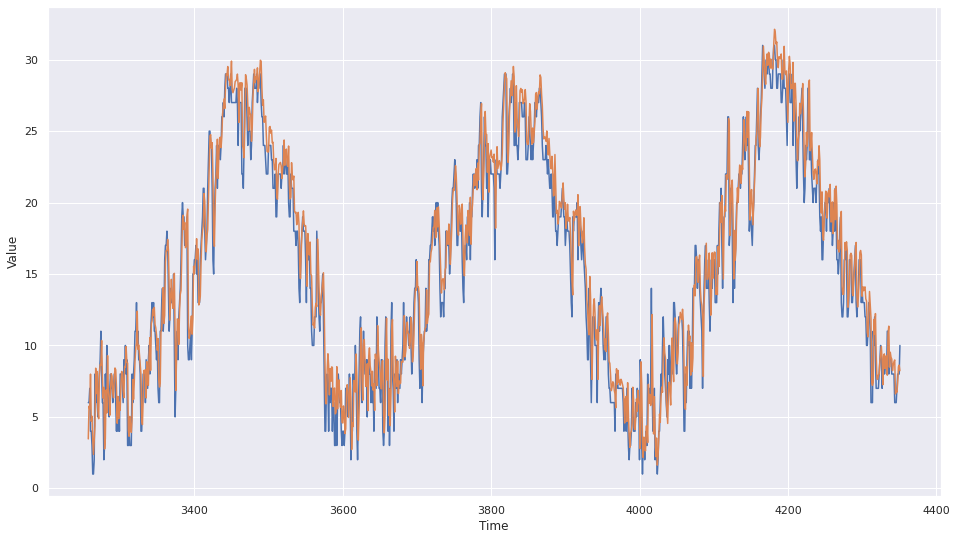

In [129]:
plt.figure(figsize=(16, 9))

plot_series(time_test, x_test)
plot_series(time_test, results)

### MAE and MSE on test set

In [130]:
mae = tf.keras.metrics.mean_absolute_error(x_test, results).numpy()
mae

1.6131334

In [131]:
mse = tf.keras.metrics.mean_squared_error(x_test, results).numpy()
mse

4.3636217

In [132]:
report = pd.DataFrame(columns=['Model', 'MAE', 'MSE'])
report.loc[len(report)] = ['Univariate 3 layer DNN 16 + Adam', mae, mse]

## Model v2 - Conv1D, 2x LSTM, 3 layer DNN, Lambda - MAE: 1.8

### Hyperparameter tuning

In [133]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set =       windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
validation_set =  windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
test_set =        windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

### Model architecture

In [134]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
#optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
#model.compile(loss=tf.keras.losses.Huber(),
#              optimizer=optimizer,
#              metrics=["mae"])

#model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9), metrics=['mae'])
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 16)          528       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           17        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

### Setup and train our model

In [135]:
checkpoint_filepath = 'Time-Series-Prediction-Weather-data-Madrid-v2.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                                                      monitor='val_loss', mode='auto', save_best_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [136]:
#history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [137]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [138]:
history_v2 = model.fit(train_set,
                       validation_data = validation_set,
                       epochs=100,
                       verbose=1,
                       callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
13/13 [==============================] - 1s 76ms/step - loss: 567.1725 - mae: 15.5342 - val_loss: 34.5743 - val_mae: 4.6183
Epoch 2/100
13/13 [==============================] - 0s 36ms/step - loss: 27.7684 - mae: 4.1791 - val_loss: 18.4356 - val_mae: 3.5112
Epoch 3/100
13/13 [==============================] - 0s 37ms/step - loss: 14.4028 - mae: 3.0660 - val_loss: 11.8600 - val_mae: 2.7437
Epoch 4/100
13/13 [==============================] - 0s 37ms/step - loss: 10.2507 - mae: 2.5586 - val_loss: 9.6920 - val_mae: 2.4866
Epoch 5/100
13/13 [==============================] - 0s 37ms/step - loss: 9.0465 - mae: 2.4041 - val_loss: 8.5948 - val_mae: 2.3413
Epoch 6/100
13/13 [==============================] - 0s 37ms/step - loss: 8.3400 - mae: 2.3078 - val_loss: 8.2147 - val_mae: 2.2907
Epoch 7/100
13/13 [==============================] - 0s 38ms/step - loss: 7.8947 - mae: 2.2437 - val_loss: 7.7391 - val_mae: 2.2178
Epoch 8/100
13/13 [==============================] - 0s 37ms/step -

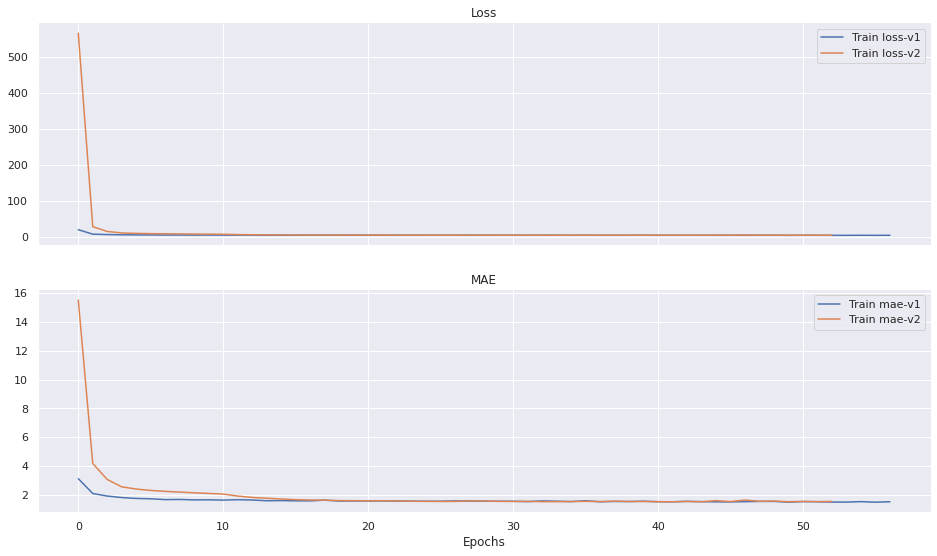

In [139]:
plot_multiple_results([history_v1, history_v2])

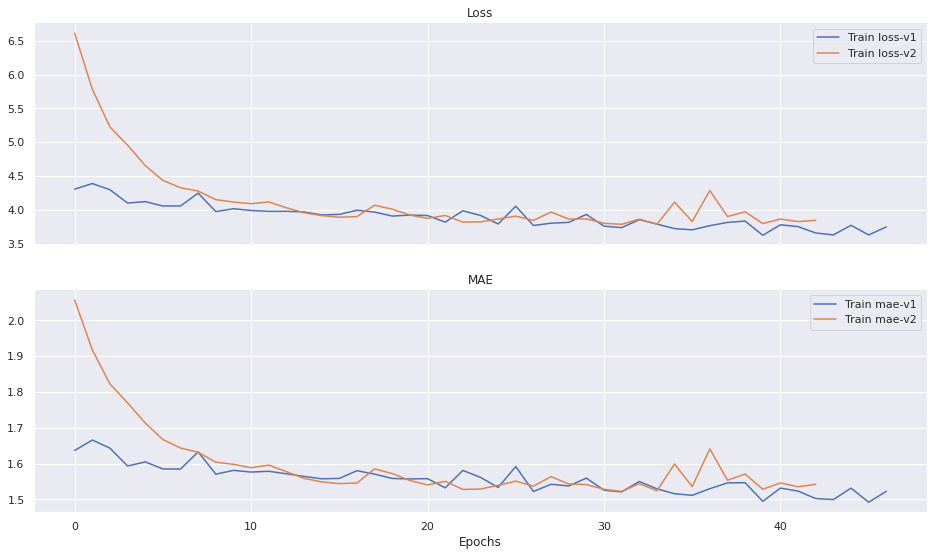

In [140]:
plot_multiple_results([history_v1, history_v2], offset=10)

In [141]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [142]:
rnn_forecast

array([1.8049154, 5.374601 , 5.5991163, ..., 8.723232 , 8.679676 ,
       8.722801 ], dtype=float32)

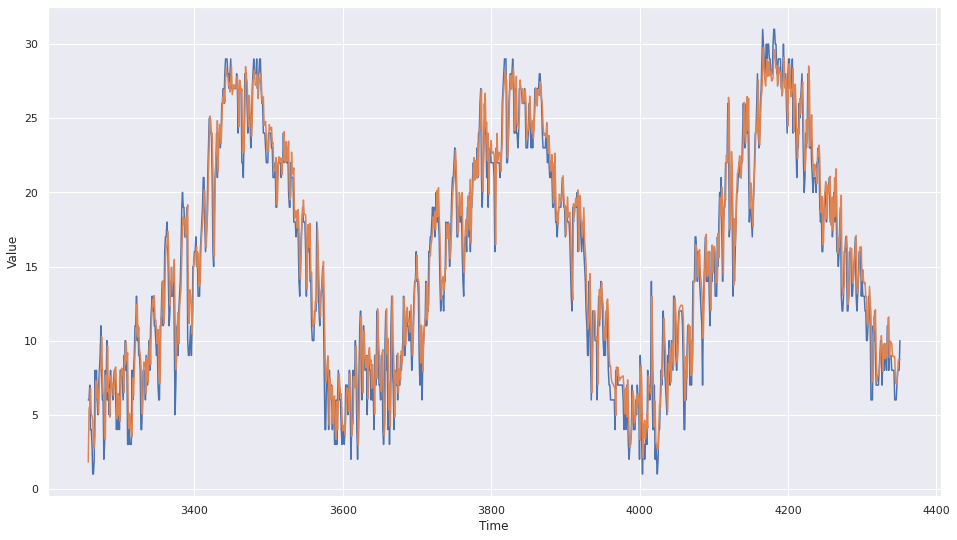

In [143]:
plt.figure(figsize=(16, 9))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)

### MAE and MSE on test set

In [144]:
mae = tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()
mae

1.5525969

In [145]:
mse = tf.keras.metrics.mean_squared_error(x_test, rnn_forecast).numpy()
mse

4.0868707

In [146]:
report.loc[len(report)] = ['Univariate Conv1D, 2x LSTM, 3 layer DNN 16 + Adam', mae, mse]

In [157]:
report

,Model,MAE,MSE
0,Univariate 3 layer DNN 10 + SGD,2.008685,6.347851
1,"Univariate Conv1D, 2x LSTM, 3 layer DNN 10 + SGD",1.801992,5.175402
2,Univariate 3 layer DNN 16 + Adam,1.613133,4.363622
3,"Univariate Conv1D, 2x LSTM, 3 layer DNN 16 + Adam",1.552597,4.086871


### Plot results of all our models 😀

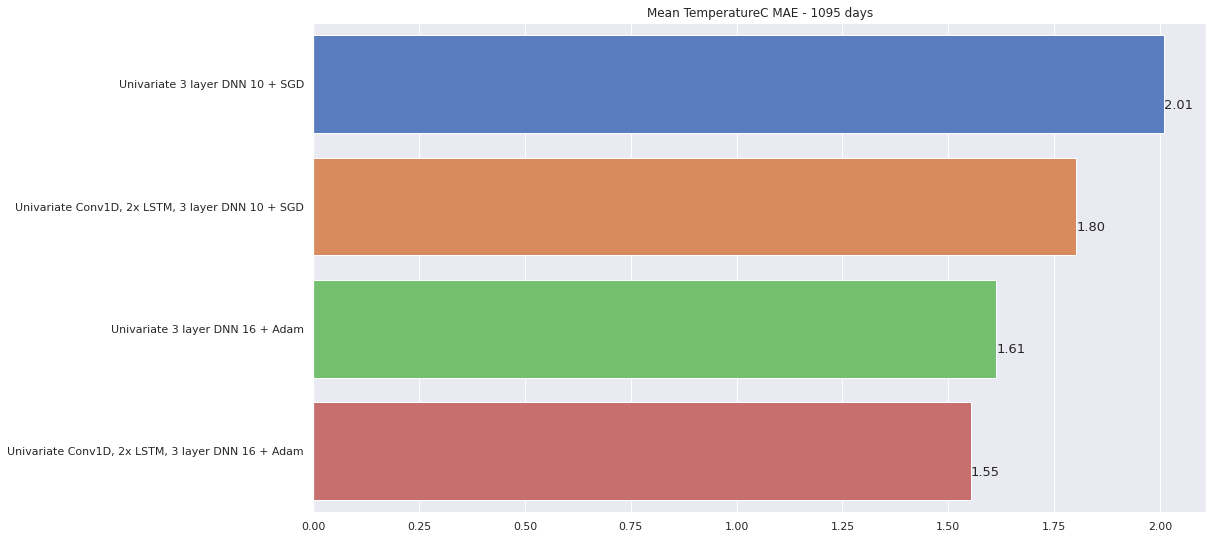

In [159]:
sns.set(rc={'figure.figsize':(16,9)})
ax = sns.barplot(report.MAE, report.Model, orient='h', palette=sns.color_palette("muted"))

for i, mae in enumerate(report.MAE):
    ax.text(mae, i+0.2, f'{mae:.2f}', fontsize=13)
plt.title(f'Mean TemperatureC MAE - {3*365} days')
plt.xlabel('')
plt.ylabel('')
plt.show()

### Extra things to consider after benchmark model above
2) Condiser using other features to predict Mean TemperatureC  
3) Consider using the entire time series dataset with the 127 missing days  
4) Do multivariate prediction, for example predict min, max and mean temperature from historical data  
5) Use statistical e.g. Arima based models  
6) Predict Events (weather description) from historical data and all features  
7) Use other time series libraries for univariate or multivariate prediction  

In [160]:
print(len(rnn_forecast))
print(rnn_forecast)

1095
[1.8049154 5.374601  5.5991163 ... 8.723232  8.679676  8.722801 ]


In [161]:
dataset.dtypes

Date                           datetime64[ns]
Max TemperatureC                      float64
Mean TemperatureC                     float64
Min TemperatureC                      float64
Dew PointC                            float64
MeanDew PointC                        float64
Min DewpointC                         float64
Max Humidity                          float64
 Mean Humidity                        float64
 Min Humidity                         float64
 Max Sea Level PressurehPa              int64
 Mean Sea Level PressurehPa             int64
 Min Sea Level PressurehPa              int64
 Max VisibilityKm                     float64
 Mean VisibilityKm                    float64
 Min VisibilitykM                     float64
 Max Wind SpeedKm/h                     int64
 Mean Wind SpeedKm/h                    int64
 Max Gust SpeedKm/h                   float64
Precipitationmm                       float64
CloudCover                            float64
Events Original                   

In [162]:
dataset.isna().sum()

Date                              0
Max TemperatureC                  0
Mean TemperatureC                 0
Min TemperatureC                  0
Dew PointC                        0
MeanDew PointC                    0
Min DewpointC                     0
Max Humidity                      0
 Mean Humidity                    0
 Min Humidity                     0
 Max Sea Level PressurehPa        0
 Mean Sea Level PressurehPa       0
 Min Sea Level PressurehPa        0
 Max VisibilityKm               630
 Mean VisibilityKm              630
 Min VisibilitykM               630
 Max Wind SpeedKm/h               0
 Mean Wind SpeedKm/h              0
 Max Gust SpeedKm/h            1400
Precipitationmm                   0
CloudCover                     1050
Events Original                3229
WindDirDegrees                    0
Events                            0
dtype: int64